<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07C%20-%20Text%20Classification%20Deep%20Learning%20Sequential%20Models%20LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!nvidia-smi

Wed Feb  2 16:16:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W /  70W |    298MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [26]:
import zipfile
from google.colab import drive
drive.mount("/content/drive")
z= zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/YouTube-Spam-Collection-v1.zip")
Psy=pd.read_csv(z.open("Youtube01-Psy.csv"))
KatyPerry  =pd.read_csv(z.open("Youtube02-KatyPerry.csv"))
LMFAQ =pd.read_csv(z.open("Youtube03-LMFAO.csv"))
Eminem =pd.read_csv(z.open("Youtube04-Eminem.csv"))
Shakira =pd.read_csv(z.open("Youtube05-Shakira.csv"))
frames = [Psy,LMFAQ,Eminem,Shakira,KatyPerry]
dataset = pd.concat(frames)
dataset.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
5,LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc,Jason Haddad,2013-11-26T02:55:11,"Hey, check out my new website!! This site is a...",1
6,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
7,z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,0
8,z13ttt1jcraqexk2o234ghbgzxymz1zzi04,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,1
9,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


In [27]:

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 349
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


In [28]:

dataset.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [29]:
# build train and test datasets
reviews = dataset['CONTENT'].values
sentiments = dataset['CLASS'].values

train_reviews = reviews[:3500]
train_sentiments = sentiments[:3500]

test_reviews = reviews[3500:]
test_sentiments = sentiments[3500:]

In [30]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [31]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  0%|          | 0/1956 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://twitter.com/GBphotographyGB﻿" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://ubuntuone.com/40beUutVu2ZKxK4uTgPZ8K﻿" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://hackfbaccountlive.com/?ref=4604617﻿" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the docume

CPU times: user 295 ms, sys: 22.6 ms, total: 318 ms
Wall time: 299 ms


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [32]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [33]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('inspiring', 4117), ('<PAD>', 0), 1)

In [34]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [35]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=4118
Number of Documents=1956


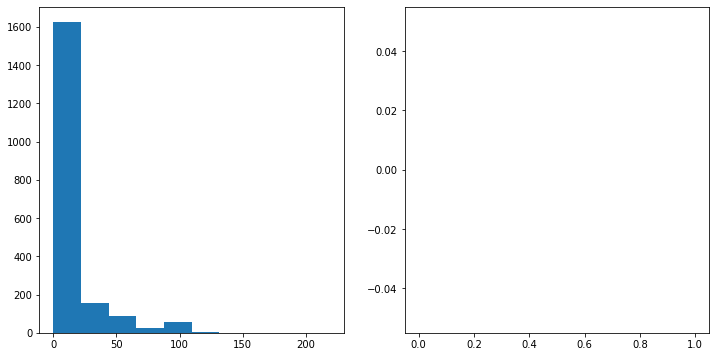

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [37]:
MAX_SEQUENCE_LENGTH = 1000

In [38]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((1956, 1000), (0, 1000))

### Encoding Labels



In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [40]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [41]:
VOCAB_SIZE = len(t.word_index)

# LSTM Model

In [42]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         1235400   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 300)        0         
 lDropout1D)                                                     
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               220160    
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,488,841
Trainable params: 1,488,841
Non-trainable params: 0
____________________________________________

## Train Model

In [43]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

In [44]:
# compiling our model
model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [46]:
batch_size = 100
history=model.fit(X_train, y_train, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
18/18 [==============================] - 2s 90ms/step - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9978 - recall: 0.9989 - val_loss: 0.3582 - val_accuracy: 0.8520 - val_precision: 0.8554 - val_recall: 0.8068
Epoch 2/5
18/18 [==============================] - 2s 87ms/step - loss: 0.0064 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.4340 - val_accuracy: 0.8469 - val_precision: 0.8452 - val_recall: 0.8068
Epoch 3/5
18/18 [==============================] - 2s 94ms/step - loss: 0.0025 - accuracy: 0.9994 - precision: 1.0000 - recall: 0.9989 - val_loss: 0.6222 - val_accuracy: 0.8469 - val_precision: 0.8222 - val_recall: 0.8409
Epoch 4/5
18/18 [==============================] - 2s 87ms/step - loss: 8.1755e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7594 - val_accuracy: 0.8418 - val_precision: 0.8434 - val_recall: 0.7955
Epoch 5/5
18/18 [==============================] - 2s 87ms/step - loss: 4.7767e-04 - accuracy: 1.0000 - prec

In [47]:
from matplotlib import pyplot

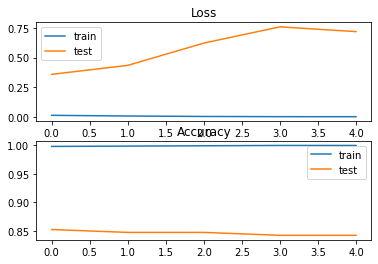

In [48]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()